# Bayesian Temporal Tensor Factorization

**Published**: December 27, 2020

**Author**: Xinyu Chen [[**GitHub homepage**](https://github.com/xinychen)]

**Download**: This Jupyter notebook is at our GitHub repository. If you want to evaluate the code, please download the notebook from the [**transdim**](https://github.com/xinychen/transdim/blob/master/predictor/BTTF.ipynb) repository.

This notebook shows how to implement the Bayesian Temporal Tensor Factorization (BTTF), a fully Bayesian matrix factorization model, on some real-world data sets. To overcome the missing data problem in multivariate time series, BTTF takes into account both low-rank matrix structure and time series autoregression. For an in-depth discussion of BTTF, please see [1].

<div class="alert alert-block alert-info">
<font color="black">
<b>[1]</b> Xinyu Chen, Lijun Sun (2019). <b>Bayesian temporal factorization for multidimensional time series prediction</b>. arXiv:1910.06366. <a href="https://arxiv.org/pdf/1910.06366.pdf" title="PDF"><b>[PDF]</b></a> 
</font>
</div>

In [1]:
import numpy as np
from numpy.linalg import inv as inv
from numpy.random import normal as normrnd
from numpy.random import multivariate_normal as mvnrnd
from scipy.linalg import khatri_rao as kr_prod
from scipy.stats import wishart
from scipy.stats import invwishart
from numpy.linalg import solve as solve
from numpy.linalg import cholesky as cholesky_lower
from scipy.linalg import cholesky as cholesky_upper
from scipy.linalg import solve_triangular as solve_ut
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def mvnrnd_pre(mu, Lambda):
    src = normrnd(size = (mu.shape[0],))
    return solve_ut(cholesky_upper(Lambda, overwrite_a = True, check_finite = False), 
                    src, lower = False, check_finite = False, overwrite_b = True) + mu

def cov_mat(mat, mat_bar):
    mat = mat - mat_bar
    return mat.T @ mat

def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

In [3]:
def sample_factor_u(tau_sparse_tensor, tau_ind, U, V, X, beta0 = 1):
    """Sampling M-by-R factor matrix U and its hyperparameters (mu_u, Lambda_u)."""
    
    dim1, rank = U.shape
    U_bar = np.mean(U, axis = 0)
    temp = dim1 / (dim1 + beta0)
    var_mu_hyper = temp * U_bar
    var_U_hyper = inv(np.eye(rank) + cov_mat(U, U_bar) + temp * beta0 * np.outer(U_bar, U_bar))
    var_Lambda_hyper = wishart.rvs(df = dim1 + rank, scale = var_U_hyper)
    var_mu_hyper = mvnrnd_pre(var_mu_hyper, (dim1 + beta0) * var_Lambda_hyper)

    var1 = kr_prod(X, V).T
    var2 = kr_prod(var1, var1)
    var3 = (var2 @ ten2mat(tau_ind, 0).T).reshape([rank, rank, dim1]) + var_Lambda_hyper[:, :, None]
    var4 = var1 @ ten2mat(tau_sparse_tensor, 0).T + (var_Lambda_hyper @ var_mu_hyper)[:, None]
    for i in range(dim1):
        U[i, :] = mvnrnd_pre(solve(var3[:, :, i], var4[:, i]), var3[:, :, i])
        
    return U

In [4]:
def sample_factor_v(tau_sparse_tensor, tau_ind, U, V, X, beta0 = 1):
    """Sampling N-by-R factor matrix V and its hyperparameters (mu_v, Lambda_v)."""
    
    dim2, rank = V.shape
    V_bar = np.mean(V, axis = 0)
    temp = dim2 / (dim2 + beta0)
    var_mu_hyper = temp * V_bar
    var_V_hyper = inv(np.eye(rank) + cov_mat(V, V_bar) + temp * beta0 * np.outer(V_bar, V_bar))
    var_Lambda_hyper = wishart.rvs(df = dim2 + rank, scale = var_V_hyper)
    var_mu_hyper = mvnrnd_pre(var_mu_hyper, (dim2 + beta0) * var_Lambda_hyper)

    var1 = kr_prod(X, U).T
    var2 = kr_prod(var1, var1)
    var3 = (var2 @ ten2mat(tau_ind, 1).T).reshape([rank, rank, dim2]) + var_Lambda_hyper[:, :, None]
    var4 = var1 @ ten2mat(tau_sparse_tensor, 1).T + (var_Lambda_hyper @ var_mu_hyper)[:, None]
    for j in range(dim2):
        V[j, :] = mvnrnd_pre(solve(var3[:, :, j], var4[:, j]), var3[:, :, j])
        
    return V

In [5]:
def mnrnd(M, U, V):
    """
    Generate matrix normal distributed random matrix.
    M is a m-by-n matrix, U is a m-by-m matrix, and V is a n-by-n matrix.
    """
    dim1, dim2 = M.shape
    X0 = np.random.randn(dim1, dim2)
    P = cholesky_lower(U)
    Q = cholesky_lower(V)
    
    return M + P @ X0 @ Q.T

def sample_var_coefficient(X, time_lags):
    dim, rank = X.shape
    d = time_lags.shape[0]
    tmax = np.max(time_lags)
    
    Z_mat = X[tmax : dim, :]
    Q_mat = np.zeros((dim - tmax, rank * d))
    for k in range(d):
        Q_mat[:, k * rank : (k + 1) * rank] = X[tmax - time_lags[k] : dim - time_lags[k], :]
    var_Psi0 = np.eye(rank * d) + Q_mat.T @ Q_mat
    var_Psi = inv(var_Psi0)
    var_M = var_Psi @ Q_mat.T @ Z_mat
    var_S = np.eye(rank) + Z_mat.T @ Z_mat - var_M.T @ var_Psi0 @ var_M
    Sigma = invwishart.rvs(df = rank + dim - tmax, scale = var_S)
    
    return mnrnd(var_M, var_Psi, Sigma), Sigma

In [6]:
def sample_factor_x(tau_sparse_tensor, tau_ind, time_lags, U, V, X, A, Lambda_x):
    """Sampling T-by-R factor matrix X."""

    dim3, rank = X.shape
    tmax = np.max(time_lags)
    tmin = np.min(time_lags)
    d = time_lags.shape[0]
    A0 = np.dstack([A] * d)
    for k in range(d):
        A0[k * rank : (k + 1) * rank, :, k] = 0
    mat0 = Lambda_x @ A.T
    mat1 = np.einsum('kij, jt -> kit', A.reshape([d, rank, rank]), Lambda_x)
    mat2 = np.einsum('kit, kjt -> ij', mat1, A.reshape([d, rank, rank]))
    
    var1 = kr_prod(V, U).T
    var2 = kr_prod(var1, var1)
    var3 = (var2 @ ten2mat(tau_ind, 2).T).reshape([rank, rank, dim3]) + Lambda_x[:, :, None]
    var4 = var1 @ ten2mat(tau_sparse_tensor, 2).T
    for t in range(dim3):
        Mt = np.zeros((rank, rank))
        Nt = np.zeros(rank)
        Qt = mat0 @ X[t - time_lags, :].reshape(rank * d)
        index = list(range(0, d))
        if t >= dim3 - tmax and t < dim3 - tmin:
            index = list(np.where(t + time_lags < dim3))[0]
        elif t < tmax:
            Qt = np.zeros(rank)
            index = list(np.where(t + time_lags >= tmax))[0]
        if t < dim3 - tmin:
            Mt = mat2.copy()
            temp = np.zeros((rank * d, len(index)))
            n = 0
            for k in index:
                temp[:, n] = X[t + time_lags[k] - time_lags, :].reshape(rank * d)
                n += 1
            temp0 = X[t + time_lags[index], :].T - np.einsum('ijk, ik -> jk', A0[:, :, index], temp)
            Nt = np.einsum('kij, jk -> i', mat1[index, :, :], temp0)
        
        var3[:, :, t] = var3[:, :, t] + Mt
        if t < tmax:
            var3[:, :, t] = var3[:, :, t] - Lambda_x + np.eye(rank)
        X[t, :] = mvnrnd_pre(solve(var3[:, :, t], var4[:, t] + Nt + Qt), var3[:, :, t])

    return X

In [7]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

In [8]:
def ar4cast(A, X, Sigma, time_lags, multi_step):
    dim, rank = X.shape
    d = time_lags.shape[0]
    X_new = np.append(X, np.zeros((multi_step, rank)), axis = 0)
    for t in range(multi_step):
        var = A.T @ X_new[dim + t - time_lags, :].reshape(rank * d)
        X_new[dim + t, :] = mvnrnd(var, Sigma)
    return X_new

#### BTTF Implementation



In [9]:
def BTTF(dense_tensor, sparse_tensor, init, rank, time_lags, burn_iter, gibbs_iter, multi_step = 1):
    """Bayesian Temporal Tensor Factorization, BTTF."""
    
    dim1, dim2, dim3 = sparse_tensor.shape
    d = time_lags.shape[0]
    U = init["U"]
    V = init["V"]
    X = init["X"]
    if np.isnan(sparse_tensor).any() == False:
        ind = sparse_tensor != 0
        pos_obs = np.where(ind)
        pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    elif np.isnan(sparse_tensor).any() == True:
        pos_test = np.where((dense_tensor != 0) & (np.isnan(sparse_tensor)))
        ind = ~np.isnan(sparse_tensor)
        pos_obs = np.where(ind)
        sparse_tensor[np.isnan(sparse_tensor)] = 0
    dense_test = dense_tensor[pos_test]
    del dense_tensor
    U_plus = np.zeros((dim1, rank, gibbs_iter))
    V_plus = np.zeros((dim2, rank, gibbs_iter))
    X_plus = np.zeros((dim3 + multi_step, rank, gibbs_iter))
    A_plus = np.zeros((rank * d, rank, gibbs_iter))
    tau_plus = np.zeros(gibbs_iter)
    Sigma_plus = np.zeros((rank, rank, gibbs_iter))
    temp_hat = np.zeros(len(pos_test[0]))
    show_iter = 500
    tau = 1
    tensor_hat_plus = np.zeros(sparse_tensor.shape)
    tensor_new_plus = np.zeros((dim1, dim2, multi_step))
    for it in range(burn_iter + gibbs_iter):
        tau_ind = tau * ind
        tau_sparse_tensor = tau * sparse_tensor
        U = sample_factor_u(tau_sparse_tensor, tau_ind, U, V, X)
        V = sample_factor_v(tau_sparse_tensor, tau_ind, U, V, X)
        A, Sigma = sample_var_coefficient(X, time_lags)
        X = sample_factor_x(tau_sparse_tensor, tau_ind, time_lags, U, V, X, A, inv(Sigma))
        tensor_hat = np.einsum('is, js, ts -> ijt', U, V, X)
        tau = np.random.gamma(1e-6 + 0.5 * np.sum(ind), 
                              1 / (1e-6 + 0.5 * np.sum(((sparse_tensor - tensor_hat) ** 2) * ind)))
        temp_hat += tensor_hat[pos_test]
        if (it + 1) % show_iter == 0 and it < burn_iter:
            temp_hat = temp_hat / show_iter
            print('Iter: {}'.format(it + 1))
            print('MAPE: {:.6}'.format(compute_mape(dense_test, temp_hat)))
            print('RMSE: {:.6}'.format(compute_rmse(dense_test, temp_hat)))
            temp_hat = np.zeros(len(pos_test[0]))
            print()
        if it + 1 > burn_iter:
            U_plus[:, :, it - burn_iter] = U
            V_plus[:, :, it - burn_iter] = V
            A_plus[:, :, it - burn_iter] = A
            Sigma_plus[:, :, it - burn_iter] = Sigma
            tau_plus[it - burn_iter] = tau
            tensor_hat_plus += tensor_hat
            X0 = ar4cast(A, X, Sigma, time_lags, multi_step)
            X_plus[:, :, it - burn_iter] = X0
            tensor_new_plus += np.einsum('is, js, ts -> ijt', U, V, X0[- multi_step :, :])
    tensor_hat = tensor_hat_plus / gibbs_iter
    print('Imputation MAPE: {:.6}'.format(compute_mape(dense_test, tensor_hat[:, :, : dim3][pos_test])))
    print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_test, tensor_hat[:, :, : dim3][pos_test])))
    print()
    tensor_hat = np.append(tensor_hat, tensor_new_plus / gibbs_iter, axis = 2)
    tensor_hat[tensor_hat < 0] = 0
    
    return tensor_hat, U_plus, V_plus, X_plus, A_plus, Sigma_plus, tau_plus

In [10]:
def sample_factor_x_partial(tau_sparse_tensor, tau_ind, time_lags, U, V, X, A, Lambda_x, back_step):
    """Sampling T-by-R factor matrix X."""
    
    dim3, rank = X.shape
    tmax = np.max(time_lags)
    tmin = np.min(time_lags)
    d = time_lags.shape[0]
    A0 = np.dstack([A] * d)
    for k in range(d):
        A0[k * rank : (k + 1) * rank, :, k] = 0
    mat0 = Lambda_x @ A.T
    mat1 = np.einsum('kij, jt -> kit', A.reshape([d, rank, rank]), Lambda_x)
    mat2 = np.einsum('kit, kjt -> ij', mat1, A.reshape([d, rank, rank]))
    
    var1 = kr_prod(V, U).T
    var2 = kr_prod(var1, var1)
    var3 = (var2 @ ten2mat(tau_ind[:, :, - back_step :], 2).T).reshape([rank, rank, back_step]) + Lambda_x[:, :, None]
    var4 = var1 @ ten2mat(tau_sparse_tensor[:, :, - back_step :], 2).T
    for t in range(dim3 - back_step, dim3):
        Mt = np.zeros((rank, rank))
        Nt = np.zeros(rank)
        Qt = mat0 @ X[t - time_lags, :].reshape(rank * d)
        index = list(range(0, d))
        if t >= dim3 - tmax and t < dim3 - tmin:
            index = list(np.where(t + time_lags < dim3))[0]
        if t < dim3 - tmin:
            Mt = mat2.copy()
            temp = np.zeros((rank * d, len(index)))
            n = 0
            for k in index:
                temp[:, n] = X[t + time_lags[k] - time_lags, :].reshape(rank * d)
                n += 1
            temp0 = X[t + time_lags[index], :].T - np.einsum('ijk, ik -> jk', A0[:, :, index], temp)
            Nt = np.einsum('kij, jk -> i', mat1[index, :, :], temp0)
        var3[:, :, t + back_step - dim3] = var3[:, :, t + back_step - dim3] + Mt
        X[t, :] = mvnrnd_pre(solve(var3[:, :, t + back_step - dim3], 
                                   var4[:, t + back_step - dim3] + Nt + Qt), var3[:, :, t + back_step - dim3])
    return X

In [11]:
def BTTF_partial(dense_tensor, sparse_tensor, init, rank, time_lags, burn_iter, gibbs_iter, multi_step = 1):
    """Bayesian Temporal Tensor Factorization, BTTF."""
    
    dim1, dim2, dim3 = sparse_tensor.shape
    U_plus = init["U_plus"]
    V_plus = init["V_plus"]
    X_plus = init["X_plus"]
    A_plus = init["A_plus"]
    Sigma_plus = init["Sigma_plus"]
    tau_plus = init["tau_plus"]
    if np.isnan(sparse_tensor).any() == False:
        ind = sparse_tensor != 0
        pos_obs = np.where(ind)
    elif np.isnan(sparse_tensor).any() == True:
        ind = ~np.isnan(sparse_tensor)
        pos_obs = np.where(ind)
        sparse_tensor[np.isnan(sparse_tensor)] = 0
    X_new_plus = np.zeros((dim3 + multi_step, rank, gibbs_iter))
    tensor_new_plus = np.zeros((dim1, dim2, multi_step))
    back_step = 10 * multi_step
    for it in range(gibbs_iter):
        tau_ind = tau_plus[it] * ind
        tau_sparse_tensor = tau_plus[it] * sparse_tensor
        X = sample_factor_x_partial(tau_sparse_tensor, tau_ind, time_lags, U_plus[:, :, it], V_plus[:, :, it],
                                    X_plus[:, :, it], A_plus[:, :, it], inv(Sigma_plus[:, :, it]), back_step)
        X0 = ar4cast(A_plus[:, :, it], X, Sigma_plus[:, :, it], time_lags, multi_step)
        X_new_plus[:, :, it] = X0
        tensor_new_plus += np.einsum('is, js, ts -> ijt', U_plus[:, :, it], V_plus[:, :, it], X0[- multi_step :, :])
    tensor_hat = tensor_new_plus / gibbs_iter
    tensor_hat[tensor_hat < 0] = 0
    
    return tensor_hat, U_plus, V_plus, X_new_plus, A_plus, Sigma_plus, tau_plus

In [12]:
from ipywidgets import IntProgress
from IPython.display import display

def BTTF_forecast(dense_tensor, sparse_tensor, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter):
    dim1, dim2, T = dense_tensor.shape
    start_time = T - pred_step
    max_count = int(np.ceil(pred_step / multi_step))
    tensor_hat = np.zeros((dim1, dim2, max_count * multi_step))
    f = IntProgress(min = 0, max = max_count) # instantiate the bar
    display(f) # display the bar
    for t in range(max_count):
        if t == 0:
            init = {"U": 0.1 * np.random.randn(dim1, rank), 
                    "V": 0.1 * np.random.randn(dim2, rank),
                    "X": 0.1 * np.random.randn(start_time, rank)}
            tensor, U, V, X_new, A, Sigma, tau = BTTF(dense_tensor[:, :, : start_time], 
                sparse_tensor[:, :, : start_time], init, rank, time_lags, burn_iter, gibbs_iter, multi_step)
        else:
            init = {"U_plus": U, "V_plus": V, "X_plus": X_new, "A_plus": A, "Sigma_plus": Sigma, "tau_plus": tau}
            tensor, U, V, X_new, A, Sigma, tau = BTTF_partial(dense_tensor[:, :, : start_time + t * multi_step], 
                sparse_tensor[:, :, : start_time + t * multi_step], init, rank, time_lags, burn_iter, gibbs_iter, multi_step)
        tensor_hat[:, :, t * multi_step : (t + 1) * multi_step] = tensor[:, :, - multi_step :]
        f.value = t
    small_dense_tensor = dense_tensor[:, :, start_time : T]
    pos = np.where(small_dense_tensor != 0)
    print('Prediction MAPE: {:.6}'.format(compute_mape(small_dense_tensor[pos], tensor_hat[pos])))
    print('Prediction RMSE: {:.6}'.format(compute_rmse(small_dense_tensor[pos], tensor_hat[pos])))
    print()
    return tensor_hat

## Eavluation on NYC Taxi Flow Data

**Scenario setting**:

- Tensor size: $30\times 30\times 1461$ (origin, destination, time)
- Test on original data


In [13]:
import scipy.io
import warnings
warnings.simplefilter('ignore')

dense_tensor = scipy.io.loadmat('../datasets/NYC-data-set/tensor.mat')['tensor'].astype(np.float32)
rm_tensor = scipy.io.loadmat('../datasets/NYC-data-set/rm_tensor.mat')['rm_tensor']
sparse_tensor = dense_tensor.copy()

**Model setting**:

- Low rank: 30
- Total (rolling) prediction horizons: 7 * 24
- Time lags: {1, 2, 24, 24 + 1, 24 + 2, 7 * 24, 7 * 24 + 1, 7 * 24 + 2}
- The number of burn-in iterations: 1000
- The number of Gibbs iterations: 200

In [14]:
import time
rank = 30
pred_step = 7 * 24
time_lags = np.array([1, 2, 3, 24, 25, 26, 7 * 24, 7 * 24 + 1, 7 * 24 + 2])
burn_iter = 1000
gibbs_iter = 200
multi_step = 2
start = time.time()
print('Prediction time horizon (delta) = {}.'.format(multi_step))
tensor_hat = BTTF_forecast(dense_tensor, sparse_tensor, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))
print()

Prediction time horizon (delta) = 2.


IntProgress(value=0, max=84)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.539244
Prediction RMSE: 5.09087

Running time: 1458 seconds



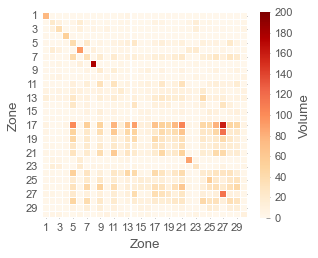

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('classic')
plt.style.use('ggplot')
plt.style.use('bmh')

plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize = (4, 3.1))
ax = fig.add_axes([0.12, 0.14, 0.80, 0.83])
ax = sns.heatmap(tensor_hat[:, :, 24 * 3 + 8], cmap = 'OrRd', vmin = 0, vmax = 200, linewidth = 0.01,
                cbar_kws={'label': 'Volume'})
plt.xticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
plt.yticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
ax.set_xlabel("Zone")
ax.set_ylabel("Zone")
plt.show()
fig.savefig("../images/Ndata_heatmap_predicted_values_32_0.pdf")

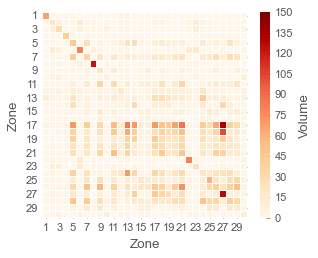

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('classic')
plt.style.use('ggplot')
plt.style.use('bmh')

plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize = (4, 3.1))
ax = fig.add_axes([0.12, 0.14, 0.80, 0.83])
ax = sns.heatmap(tensor_hat[:, :, 24 * 3 + 9], cmap = 'OrRd', vmin = 0, vmax = 150, linewidth = 0.01,
                cbar_kws={'label': 'Volume'})
plt.xticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
plt.yticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
ax.set_xlabel("Zone")
ax.set_ylabel("Zone")
plt.show()
fig.savefig("../images/Ndata_heatmap_predicted_values_33_0.pdf")

**Scenario setting**:

- Tensor size: $30\times 30\times 1461$ (origin, destination, time)
- Non-random missing (NM)
- 40% missing rate


In [19]:
import scipy.io

dense_tensor = scipy.io.loadmat('../datasets/NYC-data-set/tensor.mat')['tensor'].astype(np.float32)
nm_tensor = scipy.io.loadmat('../datasets/NYC-data-set/nm_tensor.mat')['nm_tensor']
missing_rate = 0.4

## Non-random missing (NM)
binary_tensor = np.zeros(dense_tensor.shape)
for i1 in range(dense_tensor.shape[0]):
    for i2 in range(dense_tensor.shape[1]):
        for i3 in range(61):
            binary_tensor[i1, i2, i3 * 24 : (i3 + 1) * 24] = np.round(nm_tensor[i1, i2, i3] + 0.5 - missing_rate)
sparse_tensor = dense_tensor.copy()
sparse_tensor[binary_tensor == 0] = np.nan

**Model setting**:

- Low rank: 30
- Total (rolling) prediction horizons: 7 * 24
- Time lags: {1, 2, 24, 24 + 1, 24 + 2, 7 * 24, 7 * 24 + 1, 7 * 24 + 2}
- The number of burn-in iterations: 1000
- The number of Gibbs iterations: 200

In [20]:
import time
rank = 30
pred_step = 7 * 24
time_lags = np.array([1, 2, 3, 24, 25, 26, 7 * 24, 7 * 24 + 1, 7 * 24 + 2])
burn_iter = 1000
gibbs_iter = 200
multi_step = 2
start = time.time()
print('Prediction time horizon (delta) = {}.'.format(multi_step))
tensor_hat = BTTF_forecast(dense_tensor, sparse_tensor, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
end = time.time()
print('Running time: %d seconds'%(end - start))
print()

Prediction time horizon (delta) = 2.


IntProgress(value=0, max=84)

Iter: 500
MAPE: 0.479928
RMSE: 5.28403

Iter: 1000
MAPE: 0.488142
RMSE: 5.48013

Imputation MAPE: 0.488945
Imputation RMSE: 5.49332

Prediction MAPE: 0.491979
Prediction RMSE: 6.02316

Running time: 1545 seconds



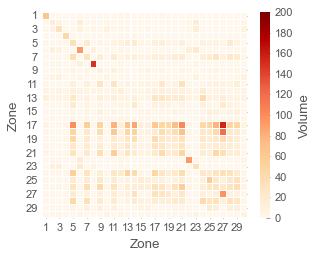

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('classic')
plt.style.use('ggplot')
plt.style.use('bmh')

plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize = (4, 3.1))
ax = fig.add_axes([0.12, 0.14, 0.80, 0.83])
ax = sns.heatmap(tensor_hat[:, :, 24 * 3 + 8], cmap = 'OrRd', vmin = 0, vmax = 200, linewidth = 0.01,
                cbar_kws={'label': 'Volume'})
plt.xticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
plt.yticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
ax.set_xlabel("Zone")
ax.set_ylabel("Zone")
plt.show()
fig.savefig("../images/Ndata_heatmap_predicted_values_32.pdf")

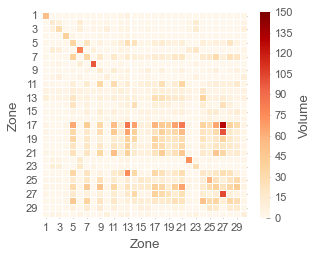

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('classic')
plt.style.use('ggplot')
plt.style.use('bmh')

plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize = (4, 3.1))
ax = fig.add_axes([0.12, 0.14, 0.80, 0.83])
ax = sns.heatmap(tensor_hat[:, :, 24 * 3 + 9], cmap = 'OrRd', vmin = 0, vmax = 150, linewidth = 0.01,
                cbar_kws={'label': 'Volume'})
plt.xticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
plt.yticks(np.arange(0.5, 30, 2), ["1", "3", "5", "7", "9", 
                                "11", "13", "15", "17", "19", 
                                "21", "23", "25", "27", "29"], rotation = 0)
ax.set_xlabel("Zone")
ax.set_ylabel("Zone")
plt.show()
fig.savefig("../images/Ndata_heatmap_predicted_values_33.pdf")

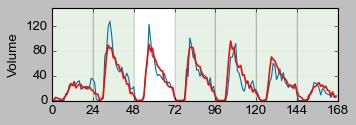

In [45]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

small_dense_tensor = dense_tensor[:, :, - pred_step :]
small_sparse_tensor = sparse_tensor[:, :, - pred_step :]

plt.style.use('classic')
plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize=(4.25, 1.55))
ax = fig.add_axes([0.14, 0.20, 0.84, 0.75])
plt.plot(small_dense_tensor[16, 12, :], color = "#006ea3",linewidth = 1.0, label = "Actual value")
plt.plot(tensor_hat[16, 12, :], color = "#e3120b", linewidth = 1.5, label = "Predicted value")
ax.set_xlim([0, pred_step])
ax.set_ylim([0, 150])
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.2)
for j in range(7):
    if small_sparse_tensor[16, 12, 24 * j] > 0:
        someX, someY = j * 24, 0
        currentAxis = plt.gca()
        ax.add_patch(patches.Rectangle((someX, someY), 24, 300, alpha = 0.1, facecolor = 'green'))

plt.xticks(np.arange(0, 7 * 24 + 1, 24))
plt.yticks(np.arange(0, 150, 40))
ax.set_ylabel("Volume")
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.4, alpha = 0.5, axis = 'x')
plt.show()
fig.savefig("../images/NYC_time_series_volume_1713.pdf")

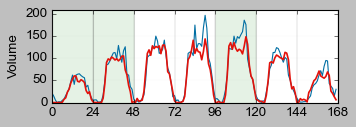

In [46]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

small_dense_tensor = dense_tensor[:, :, - pred_step :]
small_sparse_tensor = sparse_tensor[:, :, - pred_step :]

plt.style.use('classic')
plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize=(4.25, 1.55))
ax = fig.add_axes([0.14, 0.20, 0.84, 0.75])
plt.plot(small_dense_tensor[26, 26, :], color = "#006ea3",linewidth = 1.0, label = "Actual value")
plt.plot(tensor_hat[26, 26, :], color = "#e3120b", linewidth = 1.5, label = "Predicted value")
ax.set_xlim([0, pred_step])
ax.set_ylim([0, 210])
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.2)
for j in range(7):
    if small_sparse_tensor[26, 26, 24 * j] > 0:
        someX, someY = j * 24, 0
        currentAxis = plt.gca()
        ax.add_patch(patches.Rectangle((someX, someY), 24, 300, alpha = 0.1, facecolor = 'green'))

plt.xticks(np.arange(0, 7 * 24 + 1, 24))
plt.yticks(np.arange(0, 210, 50))
ax.set_ylabel("Volume")
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.4, alpha = 0.5, axis = 'x')
plt.show()
fig.savefig("../images/NYC_time_series_volume_2727.pdf")

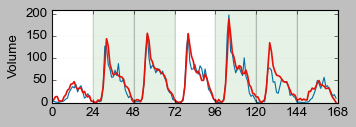

In [47]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

small_dense_tensor = dense_tensor[:, :, - pred_step :]
small_sparse_tensor = sparse_tensor[:, :, - pred_step :]

plt.style.use('classic')
plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize=(4.25, 1.55))
ax = fig.add_axes([0.14, 0.20, 0.84, 0.75])
plt.plot(small_dense_tensor[16, 26, :], color = "#006ea3",linewidth = 1.0, label = "Actual value")
plt.plot(tensor_hat[16, 26, :], color = "#e3120b", linewidth = 1.5, label = "Predicted value")
ax.set_xlim([0, pred_step])
ax.set_ylim([0, 210])
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.2)
for j in range(7):
    if small_sparse_tensor[16, 26, 24 * j] > 0:
        someX, someY = j * 24, 0
        currentAxis = plt.gca()
        ax.add_patch(patches.Rectangle((someX, someY), 24, 300, alpha = 0.1, facecolor = 'green'))

plt.xticks(np.arange(0, 7 * 24 + 1, 24))
plt.yticks(np.arange(0, 210, 50))
ax.set_ylabel("Volume")
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.4, alpha = 0.5, axis = 'x')
plt.show()
fig.savefig("../images/NYC_time_series_volume_1727.pdf")

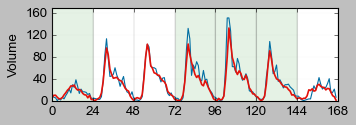

In [48]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

small_dense_tensor = dense_tensor[:, :, - pred_step :]
small_sparse_tensor = sparse_tensor[:, :, - pred_step :]

plt.style.use('classic')
plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize=(4.25, 1.55))
ax = fig.add_axes([0.14, 0.20, 0.84, 0.75])
plt.plot(small_dense_tensor[16, 20, :], color = "#006ea3",linewidth = 1.0, label = "Actual value")
plt.plot(tensor_hat[16, 20, :], color = "#e3120b", linewidth = 1.5, label = "Predicted value")
ax.set_xlim([0, pred_step])
ax.set_ylim([0, 170])
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.2)
for j in range(7):
    if small_sparse_tensor[16, 20, 24 * j] > 0:
        someX, someY = j * 24, 0
        currentAxis = plt.gca()
        ax.add_patch(patches.Rectangle((someX, someY), 24, 300, alpha = 0.1, facecolor = 'green'))

plt.xticks(np.arange(0, 7 * 24 + 1, 24))
plt.yticks(np.arange(0, 170, 40))
ax.set_ylabel("Volume")
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.4, alpha = 0.5, axis = 'x')
plt.show()
fig.savefig("../images/NYC_time_series_volume_1721.pdf")

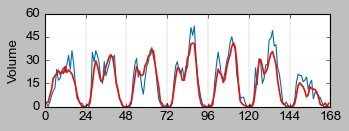

In [49]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

small_dense_tensor = dense_tensor[:, :, - pred_step :]
small_sparse_tensor = sparse_tensor[:, :, - pred_step :]

plt.style.use('classic')
plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize=(4.25, 1.55))
ax = fig.add_axes([0.14, 0.20, 0.84, 0.75])
plt.plot(small_dense_tensor[12, 20, :], color = "#006ea3",linewidth = 1.0, label = "Actual value")
plt.plot(tensor_hat[12, 20, :], color = "#e3120b", linewidth = 1.5, label = "Predicted value")
ax.set_xlim([0, pred_step])
ax.set_ylim([0, 60])
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.2)
for j in range(7):
    if small_sparse_tensor[12, 20, 24 * j] > 0:
        someX, someY = j * 24, 0
        currentAxis = plt.gca()
        ax.add_patch(patches.Rectangle((someX, someY), 24, 300, alpha = 0.1, facecolor = 'green'))

plt.xticks(np.arange(0, 7 * 24 + 1, 24))
plt.yticks(np.arange(0, 61, 15))
ax.set_ylabel("Volume")
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.4, alpha = 0.5, axis = 'x')
plt.show()
fig.savefig("../images/NYC_time_series_volume_1321.pdf")

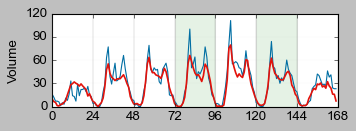

In [50]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

small_dense_tensor = dense_tensor[:, :, - pred_step :]
small_sparse_tensor = sparse_tensor[:, :, - pred_step :]

plt.style.use('classic')
plt.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize=(4.25, 1.55))
ax = fig.add_axes([0.14, 0.20, 0.84, 0.75])
plt.plot(small_dense_tensor[25, 20, :], color = "#006ea3",linewidth = 1.0, label = "Actual value")
plt.plot(tensor_hat[25, 20, :], color = "#e3120b", linewidth = 1.5, label = "Predicted value")
ax.set_xlim([0, pred_step])
ax.set_ylim([0, 120])
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.2)
for j in range(7):
    if small_sparse_tensor[25, 20, 24 * j] > 0:
        someX, someY = j * 24, 0
        currentAxis = plt.gca()
        ax.add_patch(patches.Rectangle((someX, someY), 24, 300, alpha = 0.1, facecolor = 'green'))

plt.xticks(np.arange(0, 7 * 24 + 1, 24))
plt.yticks(np.arange(0, 121, 30))
ax.set_ylabel("Volume")
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.4, alpha = 0.5, axis = 'x')
plt.show()
fig.savefig("../images/NYC_time_series_volume_2621.pdf")

## Evaluation on Pacific Surface Temperature Data

**Scenario setting**:

- Tensor size: $30\times 84\times 396$ (location x, location y, month)
- Test on original data

In [13]:
import numpy as np
import warnings
warnings.simplefilter('ignore')

dense_tensor = np.load('../datasets/Temperature-data-set/tensor.npy').astype(np.float32)
pos = np.where(dense_tensor[:, 0, :] > 50)
dense_tensor[pos[0], :, pos[1]] = 0
sparse_tensor = dense_tensor.copy()

In [14]:
import time
rank = 30
pred_step = 10 * 12
time_lags = np.array([1, 2, 3, 12, 13, 14, 2 * 12, 2 * 12 + 1, 2 * 12 + 2])
burn_iter = 1000
gibbs_iter = 200
for multi_step in [2, 4, 6]:
    start = time.time()
    print('Prediction time horizon (delta) = {}.'.format(multi_step))
    tensor_hat = BTTF_forecast(dense_tensor, sparse_tensor, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
    end = time.time()
    print('Running time: %d seconds'%(end - start))
    print()

Prediction time horizon (delta) = 2.


IntProgress(value=0, max=60)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.025427
Prediction RMSE: 0.826847

Running time: 930 seconds

Prediction time horizon (delta) = 4.


IntProgress(value=0, max=30)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.0293839
Prediction RMSE: 0.950799

Running time: 878 seconds

Prediction time horizon (delta) = 6.


IntProgress(value=0, max=20)

Iter: 500
MAPE: nan
RMSE: nan

Iter: 1000
MAPE: nan
RMSE: nan

Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.0266456
Prediction RMSE: 0.868231

Running time: 869 seconds



**Scenario setting**:

- Tensor size: $30\times 84\times 396$ (location x, location y, month)
- Random missing (RM)
- 40% missing rate

In [15]:
import numpy as np
np.random.seed(1000)

dense_tensor = np.load('../datasets/Temperature-data-set/tensor.npy').astype(np.float32)
pos = np.where(dense_tensor[:, 0, :] > 50)
dense_tensor[pos[0], :, pos[1]] = 0
random_tensor = np.random.rand(dense_tensor.shape[0], dense_tensor.shape[1], dense_tensor.shape[2])
missing_rate = 0.4

## Random missing (RM)
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_tensor = dense_tensor.copy()
sparse_tensor[binary_tensor == 0] = np.nan
sparse_tensor[sparse_tensor == 0] = np.nan

In [16]:
import time
rank = 30
pred_step = 10 * 12
time_lags = np.array([1, 2, 3, 12, 13, 14, 2 * 12, 2 * 12 + 1, 2 * 12 + 2])
burn_iter = 1000
gibbs_iter = 200
for multi_step in [2, 4, 6]:
    start = time.time()
    print('Prediction time horizon (delta) = {}.'.format(multi_step))
    tensor_hat = BTTF_forecast(dense_tensor, sparse_tensor, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
    end = time.time()
    print('Running time: %d seconds'%(end - start))
    print()

Prediction time horizon (delta) = 2.


IntProgress(value=0, max=60)

Iter: 500
MAPE: 0.0145544
RMSE: 0.48426

Iter: 1000
MAPE: 0.014258
RMSE: 0.472385

Imputation MAPE: 0.0142796
Imputation RMSE: 0.471742

Prediction MAPE: 0.30622
Prediction RMSE: 8.25959

Running time: 978 seconds

Prediction time horizon (delta) = 4.


IntProgress(value=0, max=30)

Iter: 500
MAPE: 0.0147665
RMSE: 0.49118

Iter: 1000
MAPE: 0.0144851
RMSE: 0.478815

Imputation MAPE: 0.0144851
Imputation RMSE: 0.478121

Prediction MAPE: 0.0251649
Prediction RMSE: 0.814792

Running time: 931 seconds

Prediction time horizon (delta) = 6.


IntProgress(value=0, max=20)

Iter: 500
MAPE: 0.0147633
RMSE: 0.491197

Iter: 1000
MAPE: 0.014573
RMSE: 0.483284

Imputation MAPE: 0.0145773
Imputation RMSE: 0.48275

Prediction MAPE: 0.0241419
Prediction RMSE: 0.788615

Running time: 891 seconds



**Scenario setting**:

- Tensor size: $30\times 84\times 396$ (location x, location y, month)
- Random missing (RM)
- 60% missing rate

In [17]:
import numpy as np
np.random.seed(1000)

dense_tensor = np.load('../datasets/Temperature-data-set/tensor.npy').astype(np.float32)
pos = np.where(dense_tensor[:, 0, :] > 50)
dense_tensor[pos[0], :, pos[1]] = 0
random_tensor = np.random.rand(dense_tensor.shape[0], dense_tensor.shape[1], dense_tensor.shape[2])
missing_rate = 0.6

## Random missing (RM)
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_tensor = dense_tensor.copy()
sparse_tensor[binary_tensor == 0] = np.nan
sparse_tensor[sparse_tensor == 0] = np.nan

In [18]:
import time
rank = 30
pred_step = 10 * 12
time_lags = np.array([1, 2, 3, 12, 13, 14, 2 * 12, 2 * 12 + 1, 2 * 12 + 2])
burn_iter = 1000
gibbs_iter = 200
for multi_step in [2, 4, 6]:
    start = time.time()
    print('Prediction time horizon (delta) = {}.'.format(multi_step))
    tensor_hat = BTTF_forecast(dense_tensor, sparse_tensor, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
    end = time.time()
    print('Running time: %d seconds'%(end - start))
    print()

Prediction time horizon (delta) = 2.


IntProgress(value=0, max=60)

Iter: 500
MAPE: 0.0145609
RMSE: 0.485104

Iter: 1000
MAPE: 0.0144643
RMSE: 0.4799

Imputation MAPE: 0.0144504
Imputation RMSE: 0.479404

Prediction MAPE: 0.452603
Prediction RMSE: 12.0666

Running time: 979 seconds

Prediction time horizon (delta) = 4.


IntProgress(value=0, max=30)

Iter: 500
MAPE: 0.0147978
RMSE: 0.494021

Iter: 1000
MAPE: 0.0146057
RMSE: 0.485863

Imputation MAPE: 0.0146021
Imputation RMSE: 0.4851

Prediction MAPE: 0.0245041
Prediction RMSE: 0.802645

Running time: 936 seconds

Prediction time horizon (delta) = 6.


IntProgress(value=0, max=20)

Iter: 500
MAPE: 0.0148765
RMSE: 0.497091

Iter: 1000
MAPE: 0.0145596
RMSE: 0.485001

Imputation MAPE: 0.0144894
Imputation RMSE: 0.482382

Prediction MAPE: 0.0246931
Prediction RMSE: 0.803814

Running time: 907 seconds



**Scenario setting**:

- Tensor size: $30\times 84\times 396$ (location x, location y, month)
- Non-random missing (NM)
- 40% missing rate

In [19]:
import numpy as np
np.random.seed(1000)

dense_tensor = np.load('../datasets/Temperature-data-set/tensor.npy').astype(np.float32)
pos = np.where(dense_tensor[:, 0, :] > 50)
dense_tensor[pos[0], :, pos[1]] = 0
random_tensor = np.random.rand(dense_tensor.shape[0], dense_tensor.shape[1], int(dense_tensor.shape[2] / 3))
missing_rate = 0.4

## Non-random missing (NM)
binary_tensor = np.zeros(dense_tensor.shape)
for i1 in range(dense_tensor.shape[0]):
    for i2 in range(dense_tensor.shape[1]):
        for i3 in range(int(dense_tensor.shape[2] / 3)):
            binary_tensor[i1, i2, i3 * 3 : (i3 + 1) * 3] = np.round(random_tensor[i1, i2, i3] + 0.5 - missing_rate)
sparse_tensor = dense_tensor.copy()
sparse_tensor[binary_tensor == 0] = np.nan
sparse_tensor[sparse_tensor == 0] = np.nan

In [20]:
import time
rank = 30
pred_step = 10 * 12
time_lags = np.array([1, 2, 3, 12, 13, 14, 2 * 12, 2 * 12 + 1, 2 * 12 + 2])
burn_iter = 1000
gibbs_iter = 200
for multi_step in [2, 4, 6]:
    start = time.time()
    print('Prediction time horizon (delta) = {}.'.format(multi_step))
    tensor_hat = BTTF_forecast(dense_tensor, sparse_tensor, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
    end = time.time()
    print('Running time: %d seconds'%(end - start))
    print()

Prediction time horizon (delta) = 2.


IntProgress(value=0, max=60)

Iter: 500
MAPE: 0.0149072
RMSE: 0.497672

Iter: 1000
MAPE: 0.0146636
RMSE: 0.486758

Imputation MAPE: 0.0146111
Imputation RMSE: 0.484316

Prediction MAPE: 0.305773
Prediction RMSE: 8.2862

Running time: 990 seconds

Prediction time horizon (delta) = 4.


IntProgress(value=0, max=30)

Iter: 500
MAPE: 0.0148232
RMSE: 0.494996

Iter: 1000
MAPE: 0.0146713
RMSE: 0.488526

Imputation MAPE: 0.0145447
Imputation RMSE: 0.483743

Prediction MAPE: 0.0244348
Prediction RMSE: 0.796114

Running time: 900 seconds

Prediction time horizon (delta) = 6.


IntProgress(value=0, max=20)

Iter: 500
MAPE: 0.0151393
RMSE: 0.504856

Iter: 1000
MAPE: 0.0147501
RMSE: 0.490257

Imputation MAPE: 0.0146761
Imputation RMSE: 0.487509

Prediction MAPE: 0.0248215
Prediction RMSE: 0.811801

Running time: 611 seconds



### License

<div class="alert alert-block alert-danger">
<b>This work is released under the MIT license.</b>
</div>